In [2]:
## fasttest

import gensim
import numpy as np
# Load the FastText pre-trained model
model = gensim.models.fasttext.load_facebook_model('cc.en.300.bin')

def get_fasttext_vector(line):
    vec = np.zeros(300) # Initialize an empty 300-dimensional vector
    for word in line.split():
        vec += model.wv[word]
    vec /= len(line.split()) # Take the average over all words in the line
    return vec

positive_text = """Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone"""
negative_text = """First, these should be called Mac - Coconut bars, as Coconut is the #2 ingredient and Mango is #3.  Second, lots of people don't like coconut.  I happen to be allergic to it.  Word to Amazon that if you want happy customers to make things like this more prominent.  Thanks."""

positive_example_in_fasttext = get_fasttext_vector(positive_text)
negative_example_in_fasttext = get_fasttext_vector(negative_text)

positive_review_in_fasttext = get_fasttext_vector("An Amazon review with a positive sentiment.")
negative_review_in_fasttext = get_fasttext_vector('An Amazon review with a negative sentiment.')

from openai.embeddings_utils import cosine_similarity

def get_fasttext_score(sample_embedding):
  return cosine_similarity(sample_embedding, positive_review_in_fasttext) - cosine_similarity(sample_embedding, negative_review_in_fasttext)

positive_score = get_fasttext_score(positive_example_in_fasttext)
negative_score = get_fasttext_score(negative_example_in_fasttext)

print("Fasttext好评例子的评分 : %f" % (positive_score))
print("Fasttext差评例子的评分 : %f" % (negative_score))

Fasttext好评例子的评分 : -0.000544
Fasttext差评例子的评分 : 0.000369


In [3]:
## t5
from transformers import T5Tokenizer, T5Model
import torch

# load the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)
model = T5Model.from_pretrained('t5-small')

# set the model to evaluation mode
model.eval()

# encode the input sentence
def get_t5_vector(line):
    input_ids = tokenizer.encode(line, return_tensors='pt', max_length=512, truncation=True)
    # generate the vector representation
    with torch.no_grad():
        outputs = model.encoder(input_ids=input_ids)
        vector = outputs.last_hidden_state.mean(dim=1)
    return vector[0]

positive_review_in_t5 = get_t5_vector("An Amazon review with a positive sentiment.")
negative_review_in_t5 = get_t5_vector('An Amazon review with a negative sentiment.')

def test_t5():
  positive_example_in_t5 = get_t5_vector(positive_text)
  negative_example_in_t5 = get_t5_vector(negative_text)

  def get_t5_score(sample_embedding):
    return cosine_similarity(sample_embedding, positive_review_in_t5) - cosine_similarity(sample_embedding, negative_review_in_t5)

  positive_score = get_t5_score(positive_example_in_t5)
  negative_score = get_t5_score(negative_example_in_t5)

  print("T5好评例子的评分 : %f" % (positive_score))
  print("T5差评例子的评分 : %f" % (negative_score))

test_t5()

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


T5好评例子的评分 : -0.010294
T5差评例子的评分 : -0.008990


In [4]:
## t5 
tokenizer = T5Tokenizer.from_pretrained('t5-base', model_max_length=512)
model = T5Model.from_pretrained('t5-base')

# set the model to evaluation mode
model.eval()

# encode the input sentence
def get_t5_vector(line):
    input_ids = tokenizer.encode(line, return_tensors='pt', max_length=512, truncation=True)
    # generate the vector representation
    with torch.no_grad():
        outputs = model.encoder(input_ids=input_ids)
        vector = outputs.last_hidden_state.mean(dim=1)
    return vector[0]

positive_review_in_t5 = get_t5_vector("An Amazon review with a positive sentiment.")
negative_review_in_t5 = get_t5_vector('An Amazon review with a negative sentiment.')

test_t5()

T5好评例子的评分 : 0.010347
T5差评例子的评分 : -0.023935


              precision    recall  f1-score   support

    negative       0.60      0.90      0.72       136
    positive       0.98      0.90      0.94       789

    accuracy                           0.90       925
   macro avg       0.79      0.90      0.83       925
weighted avg       0.93      0.90      0.91       925



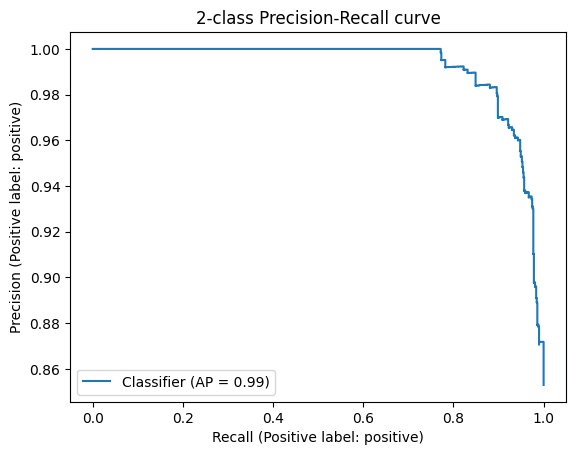

In [7]:
import pandas as pd
from sklearn.metrics import classification_report

datafile_path = "data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)

df["t5_embedding"] = df.Text.apply(get_t5_vector)
# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})

from sklearn.metrics import PrecisionRecallDisplay
def evaluate_embeddings_approach():
    def label_score(review_embedding):
        return cosine_similarity(review_embedding, positive_review_in_t5) - cosine_similarity(review_embedding, negative_review_in_t5)

    probas = df["t5_embedding"].apply(lambda x: label_score(x))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

training_data = pd.read_parquet("data/toutiao_cat_data_all_with_embeddings.parquet")
training_data.head()

df =  training_data.sample(50000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.category, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)